In [1]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [2]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

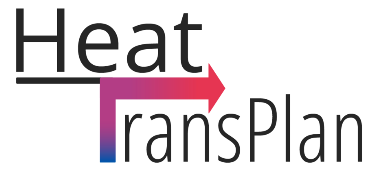


<div style="text-align: center; font-size: 50px;">
    <b>Exploratory Data Analysis</b>
</div>

## Index
- [Check the format of the variables](#format-of-the-variables)
- [Visualize the all the variables together per hour](#Visualize-the-all-the-variables-together-per-hour)
- [Process Mining: tables, case ide and activities](#Process-Mining)
- [Process Mining: process discovery schritt_l01](#Process-discovery-visual)
- [Visualize all variables per minute](#Visualize-all-variables-per-minute)
- [Visualize all variables per hour](#Visualize-all-variables-per-hour)


In [3]:
import pandas as pd
import random
import itertools
import os
import numpy as np
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
#import simulation
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chardet
import plotly.io as pio
import chardet#
import pandas as pd
from pathlib import Path
pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None
from functools import reduce

In [4]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/eckes_granini' folder relative to the current path
files_folder = current_path.parent.parent.parent/ 'data' / 'bronze' / 'eckes_granini'

files_folder

PosixPath('/Users/davidzapata/Documents/GitHub/process_energy_demand_modelling/data/bronze/eckes_granini')

# Load and join the individual dfs

In [5]:
import os
import pandas as pd

def merge_excel_files(path_folder):
    dfs_five = []
    dfs_not_five = []

    for root, dirs, files in os.walk(path_folder):
        if "Daten" in os.path.basename(root):
            print(f"\nProcessing directory: {root}")
            for file in files:
                if (file.endswith(".xlsx") or file.endswith(".xls")) and not file.startswith('~$'):
                    file_path = os.path.join(root, file)
                    try:
                        print(f"\n  Adding file: {file_path}")
                        data = pd.read_excel(file_path)
                        folder = os.path.basename(root)
                        file_no_ext = os.path.splitext(file)[0]
                        data = data.rename(columns={'Datum / Uhrzeit': 'datetime'})
                        data.columns = ['datetime' if col == 'datetime' else f"{folder}_{file_no_ext}_{col}" 
                                        for col in data.columns]
                        if 'datetime' in data.columns:
                            data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
                            # -------- Data quality checks start here --------
                            print("  Data Quality Report:")
                            dtype = data['datetime'].dtype
                            print(f"    dtype of 'datetime': {dtype}")
                            print(f"    Number of rows: {len(data)}")
                            print(f"    Earliest datetime: {data['datetime'].min()}")
                            print(f"    Latest datetime:   {data['datetime'].max()}")
                            is_datetime = pd.api.types.is_datetime64_any_dtype(data['datetime'])
                            print(f"    Column is datetime: {is_datetime}")
                            sorted_dates = data['datetime'].sort_values()
                            intervals = sorted_dates.diff().dt.total_seconds().dropna()
                            if len(intervals):
                                mean_interval = intervals.mean()
                                median_interval = intervals.median()
                                most_frequent = intervals.mode()[0]
                                print(f"    Mean interval (s): {mean_interval:.2f}")
                                print(f"    Median interval (s): {median_interval:.2f}")
                                print(f"    Most frequent interval (s): {most_frequent}")

                                if median_interval == 5:
                                    dfs_five.append(data)
                                else:
                                    dfs_not_five.append(data)
                            else:
                                print(f"    Not enough data to calculate intervals")
                                dfs_not_five.append(data)
                            # -------- Data quality checks end here --------
                        else:
                            print(f"  Skipping file {file_path} because it does not contain 'datetime' column.")
                    except Exception as e:
                        print(f"  Failed to read {file_path}: {e}")
    return dfs_five, dfs_not_five

# Usage
dfs_five, dfs_not_five = merge_excel_files(files_folder)
print(f"DataFrames with median interval 5: {len(dfs_five)}")
print(f"DataFrames with median != 5: {len(dfs_not_five)}")


Processing directory: /Users/davidzapata/Documents/GitHub/process_energy_demand_modelling/data/bronze/eckes_granini/Daten 07

  Adding file: /Users/davidzapata/Documents/GitHub/process_energy_demand_modelling/data/bronze/eckes_granini/Daten 07/A041.xlsx
  Data Quality Report:
    dtype of 'datetime': datetime64[ns]
    Number of rows: 528528
    Earliest datetime: 2024-08-01 00:00:00
    Latest datetime:   2024-08-31 23:59:40
    Column is datetime: True
    Mean interval (s): 5.07
    Median interval (s): 5.00
    Most frequent interval (s): 5.0

  Adding file: /Users/davidzapata/Documents/GitHub/process_energy_demand_modelling/data/bronze/eckes_granini/Daten 07/A039.xlsx
  Data Quality Report:
    dtype of 'datetime': datetime64[ns]
    Number of rows: 528527
    Earliest datetime: 2024-08-01 00:00:00
    Latest datetime:   2024-08-31 23:59:40
    Column is datetime: True
    Mean interval (s): 5.07
    Median interval (s): 5.00
    Most frequent interval (s): 5.0

Processing direct

In [6]:
len(dfs_five) 

19

In [7]:
len(dfs_not_five)  # Check the number of DataFrames in the list

3

Mache dfs haben werte pro stunden, aber die meisten jede 5 min

# Load the excel with total steam

In [8]:
# Load the energy Excel file
df_energy_area = pd.read_excel(files_folder / 'Aufträge Energie Meldungen/Energie Istwerte PET2 KZE 08_2024.xlsx')
df_energy_area.columns = ['datetime', 'strom_PERT2_KZE', 'dampf_PET2_KZE']

df_energy_area_total = pd.read_excel(files_folder / 'Aufträge Energie Meldungen/Energie Gesamtwerte PET2 KZE 08_2024.xlsx')
df_energy_area_total.columns = ['datetime', 'strom_gesamt_PERT2_KZE', 'dampf_gesamt_PET2_KZE']

## Join the dfs per hour

In [9]:
import pandas as pd

def group_dataframes_by_hour(dfs):
    """
    Resample each DataFrame in dfs by hour, aggregating with mean.

    Parameters:
        dfs (list of pd.DataFrame): Input DataFrames with 'datetime' column.

    Returns:
        List of DataFrames grouped by hour.
    """
    dfs_by_hour = []
    for df in dfs:
        # Convert datetime column to pandas datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
            df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
        # Remove rows with missing datetimes
        df = df.dropna(subset=['datetime'])
        # Set 'datetime' as index for resampling
        df = df.set_index('datetime')
        # Group by hour and compute mean for each hour
        df_hour = df.resample('h').mean(numeric_only=True).reset_index()
        dfs_by_hour.append(df_hour)
    return dfs_by_hour

# Usage:
dfs_by_hour = group_dataframes_by_hour(dfs_not_five)
for i, df in enumerate(dfs_by_hour):
    print(f"DF #{i} grouped by hour, shape: {df.shape}")

DF #0 grouped by hour, shape: (744, 2)
DF #1 grouped by hour, shape: (744, 2)
DF #2 grouped by hour, shape: (744, 2)


In [10]:
df_to_join = dfs_by_hour 
for i, df in enumerate(df_to_join):
    n_unique = df['datetime'].nunique(dropna=True)
    n_total = len(df)
    n_na = df['datetime'].isna().sum()
    n_dupes = n_total - n_na - n_unique
    print(f"DF #{i}: {n_dupes} duplicate datetimes, {n_na} NaT/NaN, {n_unique} unique datetimes, {n_total} total rows")


DF #0: 0 duplicate datetimes, 0 NaT/NaN, 744 unique datetimes, 744 total rows
DF #1: 0 duplicate datetimes, 0 NaT/NaN, 744 unique datetimes, 744 total rows
DF #2: 0 duplicate datetimes, 0 NaT/NaN, 744 unique datetimes, 744 total rows


In [11]:
df_hour = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='outer'), dfs_by_hour)
df_hour

,datetime,Daten 08_A047_Temperatur Produkt Einlauf_30110TT001,Daten 08_A054_Durchfluss Vorlaufpumpe_30110FT301,Daten 03_A016_Temperatur vor Vorwärmer_30121TT001 (WT 2)
0,2024-08-01 00:00:00,13.062797,20968.382277,56.842858
1,2024-08-01 01:00:00,13.101989,20841.366283,56.848086
2,2024-08-01 02:00:00,12.584755,20660.258750,56.755743
3,2024-08-01 03:00:00,12.302816,22116.423300,55.673147
4,2024-08-01 04:00:00,12.650489,23755.377931,54.872090
...,...,...,...,...
739,2024-08-31 19:00:00,33.157262,5.999976,34.514266
740,2024-08-31 20:00:00,33.066666,5.999976,34.451832
741,2024-08-31 21:00:00,33.061212,5.999976,34.417184
742,2024-08-31 22:00:00,33.034273,5.999976,34.393893


## Join the dfs with 5 seconds measurements

In [12]:
dfs_five[0]#.head(5)

,datetime,Daten 07_A041_Temperatur Auslauf EG_30130TT301 (WT2)
0,2024-08-01 00:00:00,57.299999
1,2024-08-01 00:00:05,57.400002
2,2024-08-01 00:00:10,57.299999
3,2024-08-01 00:00:15,57.299999
4,2024-08-01 00:00:20,57.299999
...,...,...
528523,2024-08-31 23:59:20,32.500000
528524,2024-08-31 23:59:25,32.599998
528525,2024-08-31 23:59:30,32.599998
528526,2024-08-31 23:59:35,32.599998


In [13]:
for df in dfs_five:
    print(df.isna().sum())

datetime                                                0
Daten 07_A041_Temperatur Auslauf EG_30130TT301 (WT2)    0
dtype: int64
datetime                                                 0
Daten 07_A039_Temperatur Einlauf EG_30130TT201 (WT 2)    0
dtype: int64
datetime                                               0
Daten 09_A058_Durchfluss Kuehlturmwasser_30120FT701    0
dtype: int64
datetime                                                0
Daten 09_A055_Durchfluss Kaltwasser_30120FT601 (WT7)    0
dtype: int64
datetime                                                    0
Daten 01_A006_Kuehlturmwassertemperatur_30120TT611 (WT6)    0
dtype: int64
datetime                                                0
Daten 01_A008_Kaltwassertemperatur_30120TT621 (WT 7)    0
dtype: int64
datetime                                                  0
Daten 06_A030_Temperatur nach Kuehler_30121TT009 (WT7)    0
dtype: int64
datetime                                                           0
Daten 06_A028_Te

In [14]:
df_to_join = dfs_five
for i, df in enumerate(df_to_join):
    n_unique = df['datetime'].nunique(dropna=True)
    n_total = len(df)
    n_na = df['datetime'].isna().sum()
    n_dupes = n_total - n_na - n_unique
    print(f"DF #{i}: {n_dupes} duplicate datetimes, {n_na} NaT/NaN, {n_unique} unique datetimes, {n_total} total rows")


DF #0: 0 duplicate datetimes, 0 NaT/NaN, 528528 unique datetimes, 528528 total rows
DF #1: 0 duplicate datetimes, 0 NaT/NaN, 528527 unique datetimes, 528527 total rows
DF #2: 0 duplicate datetimes, 0 NaT/NaN, 528528 unique datetimes, 528528 total rows
DF #3: 0 duplicate datetimes, 0 NaT/NaN, 528532 unique datetimes, 528532 total rows
DF #4: 0 duplicate datetimes, 0 NaT/NaN, 528528 unique datetimes, 528528 total rows
DF #5: 0 duplicate datetimes, 0 NaT/NaN, 528527 unique datetimes, 528527 total rows
DF #6: 0 duplicate datetimes, 0 NaT/NaN, 528527 unique datetimes, 528527 total rows
DF #7: 0 duplicate datetimes, 0 NaT/NaN, 528528 unique datetimes, 528528 total rows
DF #8: 0 duplicate datetimes, 0 NaT/NaN, 528530 unique datetimes, 528530 total rows
DF #9: 0 duplicate datetimes, 0 NaT/NaN, 528531 unique datetimes, 528531 total rows
DF #10: 0 duplicate datetimes, 0 NaT/NaN, 528528 unique datetimes, 528528 total rows
DF #11: 0 duplicate datetimes, 0 NaT/NaN, 528531 unique datetimes, 528531 t

In [15]:
df_5_sec = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='outer'), dfs_five)
df_5_sec

,datetime,Daten 07_A041_Temperatur Auslauf EG_30130TT301 (WT2),Daten 07_A039_Temperatur Einlauf EG_30130TT201 (WT 2),Daten 09_A058_Durchfluss Kuehlturmwasser_30120FT701,Daten 09_A055_Durchfluss Kaltwasser_30120FT601 (WT7),Daten 01_A006_Kuehlturmwassertemperatur_30120TT611 (WT6),Daten 01_A008_Kaltwassertemperatur_30120TT621 (WT 7),Daten 06_A030_Temperatur nach Kuehler_30121TT009 (WT7),Daten 06_A028_Temperatur nach Kuehlturmkuehler_30121TT008 (WT6),Daten 11_A425_Fuellstand Steriltank_30140LT001,Daten 11_A429_Fuellstand Steriltank_30141LT001,Daten 10_A060_Durchfluss Dampf_30120FT801 WT3a/5a),Daten 10_A059_Durchfluss Heisswasser_30120FT721(WT5a),"Daten 03_A018_Temperatur nach WR2, vor Druckerhoehungspumpe_30121TT002 (WT4)",Daten 04_A020_Temperatur nach Erhitzer_30121TT004 (WT5),"Daten 04_A018_Temperatur nach WR2, vor Druckerhoehungspumpe_30121TT002 (WT4)",Daten 05_A026_Temperatur nach WR2_30121TT007 (WT2),Daten 05_A024_Temperatur nach Austauscher 2_30121TT006 (WT4),Daten 02_A011_Druck HW Anwaermer_30120PT711 (WT3a),Daten 02_A010_Temperatur HW Anwaermer_30120TT711 (WT3a)
0,2024-08-01 00:00:00,57.299999,56.700001,32022.0,56475.0,17.600000,16.400000,15.700000,17.700001,0.0,8633.342773,2.0,25564.0,87.199997,92.099998,87.199997,18.400000,61.500000,2.19,52.000000
1,2024-08-01 00:00:05,57.400002,56.700001,31987.0,56484.0,17.600000,16.400000,15.700000,17.600000,0.0,8680.342773,2.0,25381.0,87.199997,92.099998,87.199997,18.400000,61.400002,2.20,52.000000
2,2024-08-01 00:00:10,57.299999,56.700001,32048.0,56475.0,17.600000,16.400000,15.800000,17.700001,0.0,8680.342773,2.0,25538.0,87.199997,92.099998,87.199997,18.400000,61.400002,2.20,52.099998
3,2024-08-01 00:00:15,57.299999,56.799999,31979.0,56467.0,17.500000,16.400000,15.800000,17.700001,0.0,8727.343750,2.0,25633.0,87.199997,92.000000,87.199997,18.299999,61.400002,2.19,52.099998
4,2024-08-01 00:00:20,57.299999,56.700001,31970.0,56484.0,17.500000,16.400000,15.800000,17.700001,0.0,8727.343750,2.0,25651.0,87.199997,92.000000,87.199997,18.299999,61.500000,2.20,52.099998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665678,2024-08-31 23:59:30,32.599998,32.599998,8.0,17.0,32.799999,33.500000,32.799999,31.799999,0.0,0.000000,2.0,17.0,33.299999,34.400002,33.299999,30.299999,36.200001,2.13,36.599998
665679,2024-08-31 23:59:35,32.599998,32.700001,8.0,17.0,32.900002,33.299999,32.799999,31.799999,0.0,0.000000,2.0,17.0,33.299999,34.400002,33.299999,30.299999,36.200001,2.13,36.700001
665680,2024-08-31 23:59:40,32.500000,32.700001,8.0,17.0,32.799999,33.400002,32.700001,31.900000,0.0,0.000000,2.0,17.0,33.200001,34.299999,33.200001,30.200001,36.099998,2.13,36.700001
665681,2024-08-31 23:59:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_5_sec.isna().sum()

datetime                                                                             0
Daten 07_A041_Temperatur Auslauf EG_30130TT301 (WT2)                            137155
Daten 07_A039_Temperatur Einlauf EG_30130TT201 (WT 2)                           137156
Daten 09_A058_Durchfluss Kuehlturmwasser_30120FT701                             137155
Daten 09_A055_Durchfluss Kaltwasser_30120FT601 (WT7)                            137151
Daten 01_A006_Kuehlturmwassertemperatur_30120TT611 (WT6)                        137155
Daten 01_A008_Kaltwassertemperatur_30120TT621 (WT 7)                            137156
Daten 06_A030_Temperatur nach Kuehler_30121TT009 (WT7)                          137156
Daten 06_A028_Temperatur nach Kuehlturmkuehler_30121TT008 (WT6)                 137155
Daten 11_A425_Fuellstand Steriltank_30140LT001                                  137153
Daten 11_A429_Fuellstand Steriltank_30141LT001                                  137152
Daten 10_A060_Durchfluss Dampf_30120FT801 W

In [17]:
# Keep only rows with at least (total_columns - 6 + 1) non-NaN values
min_non_nan = df_5_sec.shape[1] - 6 + 1
df_5_sec_not_nan = df_5_sec.dropna(thresh=min_non_nan)
df_5_sec_not_nan

,datetime,Daten 07_A041_Temperatur Auslauf EG_30130TT301 (WT2),Daten 07_A039_Temperatur Einlauf EG_30130TT201 (WT 2),Daten 09_A058_Durchfluss Kuehlturmwasser_30120FT701,Daten 09_A055_Durchfluss Kaltwasser_30120FT601 (WT7),Daten 01_A006_Kuehlturmwassertemperatur_30120TT611 (WT6),Daten 01_A008_Kaltwassertemperatur_30120TT621 (WT 7),Daten 06_A030_Temperatur nach Kuehler_30121TT009 (WT7),Daten 06_A028_Temperatur nach Kuehlturmkuehler_30121TT008 (WT6),Daten 11_A425_Fuellstand Steriltank_30140LT001,Daten 11_A429_Fuellstand Steriltank_30141LT001,Daten 10_A060_Durchfluss Dampf_30120FT801 WT3a/5a),Daten 10_A059_Durchfluss Heisswasser_30120FT721(WT5a),"Daten 03_A018_Temperatur nach WR2, vor Druckerhoehungspumpe_30121TT002 (WT4)",Daten 04_A020_Temperatur nach Erhitzer_30121TT004 (WT5),"Daten 04_A018_Temperatur nach WR2, vor Druckerhoehungspumpe_30121TT002 (WT4)",Daten 05_A026_Temperatur nach WR2_30121TT007 (WT2),Daten 05_A024_Temperatur nach Austauscher 2_30121TT006 (WT4),Daten 02_A011_Druck HW Anwaermer_30120PT711 (WT3a),Daten 02_A010_Temperatur HW Anwaermer_30120TT711 (WT3a)
0,2024-08-01 00:00:00,57.299999,56.700001,32022.0,56475.0,17.600000,16.400000,15.700000,17.700001,0.0,8633.342773,2.0,25564.0,87.199997,92.099998,87.199997,18.400000,61.500000,2.19,52.000000
1,2024-08-01 00:00:05,57.400002,56.700001,31987.0,56484.0,17.600000,16.400000,15.700000,17.600000,0.0,8680.342773,2.0,25381.0,87.199997,92.099998,87.199997,18.400000,61.400002,2.20,52.000000
2,2024-08-01 00:00:10,57.299999,56.700001,32048.0,56475.0,17.600000,16.400000,15.800000,17.700001,0.0,8680.342773,2.0,25538.0,87.199997,92.099998,87.199997,18.400000,61.400002,2.20,52.099998
3,2024-08-01 00:00:15,57.299999,56.799999,31979.0,56467.0,17.500000,16.400000,15.800000,17.700001,0.0,8727.343750,2.0,25633.0,87.199997,92.000000,87.199997,18.299999,61.400002,2.19,52.099998
4,2024-08-01 00:00:20,57.299999,56.700001,31970.0,56484.0,17.500000,16.400000,15.800000,17.700001,0.0,8727.343750,2.0,25651.0,87.199997,92.000000,87.199997,18.299999,61.500000,2.20,52.099998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665676,2024-08-31 23:59:20,32.500000,32.700001,8.0,17.0,32.799999,33.400002,32.799999,31.799999,0.0,0.000000,2.0,17.0,33.200001,34.400002,33.200001,30.299999,36.200001,2.13,36.700001
665677,2024-08-31 23:59:25,32.599998,32.599998,8.0,17.0,32.799999,33.400002,32.799999,31.799999,0.0,0.000000,2.0,17.0,33.200001,34.400002,33.200001,30.299999,36.299999,2.13,36.700001
665678,2024-08-31 23:59:30,32.599998,32.599998,8.0,17.0,32.799999,33.500000,32.799999,31.799999,0.0,0.000000,2.0,17.0,33.299999,34.400002,33.299999,30.299999,36.200001,2.13,36.599998
665679,2024-08-31 23:59:35,32.599998,32.700001,8.0,17.0,32.900002,33.299999,32.799999,31.799999,0.0,0.000000,2.0,17.0,33.299999,34.400002,33.299999,30.299999,36.200001,2.13,36.700001


In [18]:
nan_rows = df_5_sec_not_nan[df_5_sec_not_nan.isna().any(axis=1)]
nan_rows

,datetime,Daten 07_A041_Temperatur Auslauf EG_30130TT301 (WT2),Daten 07_A039_Temperatur Einlauf EG_30130TT201 (WT 2),Daten 09_A058_Durchfluss Kuehlturmwasser_30120FT701,Daten 09_A055_Durchfluss Kaltwasser_30120FT601 (WT7),Daten 01_A006_Kuehlturmwassertemperatur_30120TT611 (WT6),Daten 01_A008_Kaltwassertemperatur_30120TT621 (WT 7),Daten 06_A030_Temperatur nach Kuehler_30121TT009 (WT7),Daten 06_A028_Temperatur nach Kuehlturmkuehler_30121TT008 (WT6),Daten 11_A425_Fuellstand Steriltank_30140LT001,Daten 11_A429_Fuellstand Steriltank_30141LT001,Daten 10_A060_Durchfluss Dampf_30120FT801 WT3a/5a),Daten 10_A059_Durchfluss Heisswasser_30120FT721(WT5a),"Daten 03_A018_Temperatur nach WR2, vor Druckerhoehungspumpe_30121TT002 (WT4)",Daten 04_A020_Temperatur nach Erhitzer_30121TT004 (WT5),"Daten 04_A018_Temperatur nach WR2, vor Druckerhoehungspumpe_30121TT002 (WT4)",Daten 05_A026_Temperatur nach WR2_30121TT007 (WT2),Daten 05_A024_Temperatur nach Austauscher 2_30121TT006 (WT4),Daten 02_A011_Druck HW Anwaermer_30120PT711 (WT3a),Daten 02_A010_Temperatur HW Anwaermer_30120TT711 (WT3a)
68215,2024-08-05 00:00:49,66.800003,66.699997,30017.0,51753.0,19.0,18.600000,18.299999,18.600000,NaN,NaN,NaN,21545.0,87.900002,90.900002,87.900002,24.0,69.300003,3.06,66.599998
68218,2024-08-05 00:00:54,66.800003,66.699997,29965.0,51545.0,19.1,18.600000,18.299999,18.600000,NaN,NaN,NaN,21579.0,88.000000,90.900002,88.000000,24.1,69.300003,3.07,66.500000
68221,2024-08-05 00:00:59,66.800003,66.599998,29791.0,51380.0,19.1,18.500000,18.299999,18.600000,NaN,NaN,NaN,21588.0,88.000000,90.900002,88.000000,24.0,69.300003,3.07,66.500000
68224,2024-08-05 00:01:04,66.800003,66.500000,29782.0,51171.0,19.1,18.500000,18.299999,18.700001,NaN,NaN,NaN,21631.0,88.000000,90.900002,88.000000,24.0,69.300003,3.07,66.500000
68227,2024-08-05 00:01:09,66.800003,66.599998,29635.0,50590.0,19.0,18.500000,18.299999,18.600000,NaN,NaN,NaN,21623.0,88.000000,90.900002,88.000000,23.9,69.300003,3.08,66.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631578,2024-08-29 23:59:45,62.299999,63.099998,32013.0,14973.0,21.0,20.200001,21.100000,21.200001,NaN,NaN,312.0,36388.0,95.800003,100.900002,95.800003,23.1,66.800003,3.31,62.799999
631580,2024-08-29 23:59:50,62.400002,63.200001,32005.0,14930.0,20.9,20.200001,21.100000,21.200001,NaN,NaN,312.0,36371.0,95.800003,100.900002,95.800003,23.1,66.800003,3.30,62.799999
631582,2024-08-30 00:00:00,62.400002,63.299999,31970.0,14939.0,21.0,20.200001,21.000000,21.100000,NaN,NaN,313.0,36397.0,95.800003,101.000000,95.800003,23.1,66.900002,3.33,63.000000
631584,2024-08-30 00:00:05,62.599998,63.400002,31875.0,14947.0,21.0,20.200001,20.900000,21.100000,NaN,NaN,313.0,36380.0,95.699997,101.000000,95.699997,23.1,66.900002,3.29,63.200001


## Final sensor join

In [19]:
df1 = df_5_sec_not_nan.copy()
df2 = df_hour.copy()
df3 = df_energy_area.copy()
df4 = df_energy_area_total.copy()

# Append suffix to df1 columns (except 'datetime')
df1.columns = [
    col + "_5s" if col != 'datetime' else col
    for col in df1.columns
]

# Append suffix to df2 columns (except 'datetime')
df2.columns = [
    col + "_1h" if col != 'datetime' else col
    for col in df2.columns
]

# Append suffix to df2 columns (except 'datetime')
df3.columns = [
    col + "_5s" if col != 'datetime' else col
    for col in df3.columns
]

# Append suffix to df2 columns (except 'datetime')
df4.columns = [
    col + "_15m" if col != 'datetime' else col
    for col in df4.columns
]

# Merge on 'datetime'
df = df1.merge(df2, on='datetime', how='left')
df = df.merge(df3, on='datetime', how='left')
df = df.merge(df4, on='datetime', how='left')

cols_1h = [col for col in df.columns if col.endswith('_1h')]
df[cols_1h] = df[cols_1h].fillna(method='ffill')

df_sensor_joined = df

/var/folders/j7/bzg541gd7dg10j_2qvx3s4j00000gn/T/ipykernel_35235/234513737.py:36: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [20]:
df_sensor_joined.columns

Index(['datetime', 'Daten 07_A041_Temperatur Auslauf EG_30130TT301 (WT2)_5s',
       'Daten 07_A039_Temperatur Einlauf EG_30130TT201 (WT 2)_5s',
       'Daten 09_A058_Durchfluss Kuehlturmwasser_30120FT701_5s',
       'Daten 09_A055_Durchfluss Kaltwasser_30120FT601 (WT7)_5s',
       'Daten 01_A006_Kuehlturmwassertemperatur_30120TT611 (WT6)_5s',
       'Daten 01_A008_Kaltwassertemperatur_30120TT621 (WT 7)_5s',
       'Daten 06_A030_Temperatur nach Kuehler_30121TT009 (WT7)_5s',
       'Daten 06_A028_Temperatur nach Kuehlturmkuehler_30121TT008 (WT6)_5s',
       'Daten 11_A425_Fuellstand Steriltank_30140LT001_5s',
       'Daten 11_A429_Fuellstand Steriltank_30141LT001_5s',
       'Daten 10_A060_Durchfluss Dampf_30120FT801 WT3a/5a)_5s',
       'Daten 10_A059_Durchfluss Heisswasser_30120FT721(WT5a)_5s',
       'Daten 03_A018_Temperatur nach WR2, vor Druckerhoehungspumpe_30121TT002 (WT4)_5s',
       'Daten 04_A020_Temperatur nach Erhitzer_30121TT004 (WT5)_5s',
       'Daten 04_A018_Temperatur 

In [21]:
import re
import pandas as pd

df = df_sensor_joined.copy()

old_cols = list(df.columns)

def process_column(col):
    original = col
    
    # Skip columns that don't start with 'Daten' (these are manually named)
    if not col.startswith('Daten'):
        return col
    
    # 1. Remove value between two spaces starting with '30'
    col = re.sub(r'(?=30)[^ ]* ', ' ', col)
    # 2. Replace all spaces with underscores
    col = col.replace(' ', '_')
    # 3. Remove everything before the second "_"
    parts = col.split('_')
    if len(parts) >= 4:  # Only process if there are enough parts
        col = '_'.join(parts[3:])
    col = col.replace('__', '_')
    
    # If result is too short, return original
    if len(col) <= 3:
        return original
    return col

df.columns = [process_column(col) for col in df.columns]

df.columns = [col.replace('Daten ', '') for col in df.columns]
df.columns = [col.replace(' ', '_') for col in df.columns]

df.columns = [col.replace('Temperatur', 'temp') for col in df.columns]
df.columns = [col.replace('temperatur', 'temp') for col in df.columns]
df.columns = [col.replace('Durchfluss', 'flow') for col in df.columns]

# Table of changes (old and new column names)
col_changes = pd.DataFrame({'old_column': old_cols, 'new_column': df.columns})


df = df.loc[:, ~df.columns.duplicated()]

df_new_columns = df.copy()
df_new_columns

,datetime,temp_Auslauf_EG_(WT2)_5s,temp_Einlauf_EG_(WT_2)_5s,flow_Kuehlturmwasser_30120FT701_5s,flow_Kaltwasser_(WT7)_5s,Kuehlturmwassertemp_(WT6)_5s,Kaltwassertemp_(WT_7)_5s,nach_Kuehler_(WT7)_5s,temp_nach_Kuehlturmkuehler_(WT6)_5s,Fuellstand_Steriltank_30140LT001_5s,...,temp_nach_Austauscher_2_(WT4)_5s,Druck_HW_Anwaermer_(WT3a)_5s,temp_HW_Anwaermer_(WT3a)_5s,temp_Produkt_Einlauf_30110TT001_1h,flow_Vorlaufpumpe_30110FT301_1h,temp_vor_Vorwärmer_(WT_2)_1h,strom_PERT2_KZE_5s,dampf_PET2_KZE_5s,strom_gesamt_PERT2_KZE_15m,dampf_gesamt_PET2_KZE_15m
0,2024-08-01 00:00:00,57.299999,56.700001,32022.0,56475.0,17.600000,16.400000,15.700000,17.700001,0.0,...,61.500000,2.19,52.000000,13.062797,20968.382277,56.842858,36.914555,2.0,1.440505e+06,2262.295899
1,2024-08-01 00:00:05,57.400002,56.700001,31987.0,56484.0,17.600000,16.400000,15.700000,17.600000,0.0,...,61.400002,2.20,52.000000,13.062797,20968.382277,56.842858,37.692829,2.0,NaN,NaN
2,2024-08-01 00:00:10,57.299999,56.700001,32048.0,56475.0,17.600000,16.400000,15.800000,17.700001,0.0,...,61.400002,2.20,52.099998,13.062797,20968.382277,56.842858,37.768864,2.0,NaN,NaN
3,2024-08-01 00:00:15,57.299999,56.799999,31979.0,56467.0,17.500000,16.400000,15.800000,17.700001,0.0,...,61.400002,2.19,52.099998,13.062797,20968.382277,56.842858,37.661293,2.0,NaN,NaN
4,2024-08-01 00:00:20,57.299999,56.700001,31970.0,56484.0,17.500000,16.400000,15.800000,17.700001,0.0,...,61.500000,2.20,52.099998,13.062797,20968.382277,56.842858,37.655125,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528494,2024-08-31 23:59:20,32.500000,32.700001,8.0,17.0,32.799999,33.400002,32.799999,31.799999,0.0,...,36.200001,2.13,36.700001,33.037872,5.999976,34.367041,0.607903,2.0,NaN,NaN
528495,2024-08-31 23:59:25,32.599998,32.599998,8.0,17.0,32.799999,33.400002,32.799999,31.799999,0.0,...,36.299999,2.13,36.700001,33.037872,5.999976,34.367041,0.617285,2.0,NaN,NaN
528496,2024-08-31 23:59:30,32.599998,32.599998,8.0,17.0,32.799999,33.500000,32.799999,31.799999,0.0,...,36.200001,2.13,36.599998,33.037872,5.999976,34.367041,0.609878,2.0,NaN,NaN
528497,2024-08-31 23:59:35,32.599998,32.700001,8.0,17.0,32.900002,33.299999,32.799999,31.799999,0.0,...,36.200001,2.13,36.700001,33.037872,5.999976,34.367041,0.602146,2.0,NaN,NaN


In [22]:
col_changes

,old_column,new_column
0,datetime,datetime
1,Daten 07_A041_Temperatur Auslauf EG_30130TT301...,temp_Auslauf_EG_(WT2)_5s
2,Daten 07_A039_Temperatur Einlauf EG_30130TT201...,temp_Einlauf_EG_(WT_2)_5s
3,Daten 09_A058_Durchfluss Kuehlturmwasser_30120...,flow_Kuehlturmwasser_30120FT701_5s
4,Daten 09_A055_Durchfluss Kaltwasser_30120FT601...,flow_Kaltwasser_(WT7)_5s
5,Daten 01_A006_Kuehlturmwassertemperatur_30120T...,Kuehlturmwassertemp_(WT6)_5s
6,Daten 01_A008_Kaltwassertemperatur_30120TT621 ...,Kaltwassertemp_(WT_7)_5s
7,Daten 06_A030_Temperatur nach Kuehler_30121TT0...,nach_Kuehler_(WT7)_5s
8,Daten 06_A028_Temperatur nach Kuehlturmkuehler...,temp_nach_Kuehlturmkuehler_(WT6)_5s
9,Daten 11_A425_Fuellstand Steriltank_30140LT001_5s,Fuellstand_Steriltank_30140LT001_5s


## Save the df

In [29]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
folder_to_save = current_path.parent.parent.parent / 'data' / 'silver' / 'company_1'

folder_to_save

PosixPath('/Users/davidzapata/Documents/GitHub/process_energy_demand_modelling/data/silver/company_1')

In [30]:
# Fix for PyArrow extension type error
df_new_columns = pd.DataFrame(df_new_columns.values, columns=df_new_columns.columns, index=df_new_columns.index)

df_new_columns.to_parquet(
    folder_to_save / 'df_sensor_joined.parquet',
    index=False,
    engine='pyarrow',
    compression='snappy'
)

# Load the df

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
folder_to_load = current_path.parent.parent.parent / 'data' / 'silver' / 'company_1'

folder_to_load

PosixPath('/Users/davidzapata/Documents/GitHub/process_energy_demand_modelling/data/bronze/company_1')

In [32]:
df_new_columns = pd.read_parquet(folder_to_load / 'df_sensor_joined_calculations.parquet', engine='pyarrow')
df_new_columns

FileNotFoundError: [Errno 2] No such file or directory: '/Users/davidzapata/Documents/GitHub/process_energy_demand_modelling/data/bronze/company_1/df_sensor_joined_calculations.parquet'

In [ ]:
for column in df_new_columns.columns:
    print(column)

In [ ]:
df = df_new_columns.copy()

# Exclude the datetime column
numeric_df = df.select_dtypes(include=['float', 'int'])

# Calculate descriptive statistics
stats_df = numeric_df.describe().loc[['mean', 'min', 'max']].T.reset_index()

# Rename columns
stats_df.columns = ['Column Name', 'Mean', 'Min', 'Max']

# Round values to one decimal place
stats_df[['Min', 'Mean', 'Max']] = stats_df[['Min', 'Mean', 'Max']].round(1)

stats_df = stats_df[['Column Name',  'Min', 'Mean', 'Max']]

# Export to Excel with formatted float values
stats_df.to_excel(folder_to_load / "descriptive_statistics.xlsx", index=True, float_format="%.1f")
stats_df

## EDA


In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def visualize_data(df, datetime_col, library="plotly"):
    """
    Visualize each variable in a DataFrame with descriptive stats, histogram, and linechart.
    
    Parameters:
    - df: pandas DataFrame
    - datetime_col: column name for datetime values
    - library: visualization library to use ('plotly' or 'seaborn')
    """
    # Ensure the datetime column is in datetime format

    # Set Seaborn theme
    sns.set_theme(style="whitegrid", context="talk")

    for col in df.columns:
        if col == datetime_col:
            continue  # Skip the datetime column

        print(f"Variable: {col}")
        print(df[col].describe())
        print(f"Unique values: {df[col].nunique()}")
        print("-" * 60)

        if library == "plotly":
            # Plotly Histograms
            fig_hist = px.histogram(df, x=col, title=f"Histogram of {col}")
            fig_hist.show()

            # Plotly Line Chart
            fig_line = px.line(df, x=datetime_col, y=col, title=f"{col}")
            fig_line.show()

        elif library == "seaborn":
            # Seaborn Histogram
            plt.figure(figsize=(20, 6))
            sns.histplot(df[col], kde=True, bins=30, color="green", edgecolor="black")
            plt.title(f"Histogram of {col}", fontsize=16)
            plt.xlabel(col, fontsize=14)
            plt.ylabel("Frequency", fontsize=14)
            plt.show()

            # Seaborn Line Chart
            plt.figure(figsize=(20, 6))
            sns.lineplot(data=df, x=datetime_col, y=col, color="green", linewidth=2.5)
            plt.title(f"{col} Over Time", fontsize=16)
            plt.xlabel("Datetime", fontsize=14)
            plt.ylabel(col, fontsize=14)
            plt.xticks(rotation=45, fontsize=12)
            plt.yticks(fontsize=12)
            plt.tight_layout()
            plt.show()

        print("=" * 200) 



- [Index](#Index)

In [ ]:
df = df_new_columns.copy()

df.set_index('datetime', inplace=True)
df_resampled_1H = df.resample('h').mean(numeric_only=True).reset_index()
df_resampled_1H

# Correlation Matrix

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming df_new_columns is already defined and contains your data
df = df_new_columns.copy()
df = df.drop(columns=['datetime'])

# Step 1: Calculate the correlation matrix
corr_matrix = df.corr()

# Step 2: Plot the heatmap using Plotly
fig = px.imshow(
    corr_matrix,
    text_auto=".1f",  # Round the correlation coefficients to one decimal place
    color_continuous_scale='RdBu',  # Red to blue color scale
    labels=dict(x="Variables", y="Variables", color="Correlation"),
    title="Correlation Matrix Heatmap",
    width=1000,
    height=1000
)

print('Correlation in 5 Min spans')

# Hide the color bar (legend)
fig.update_coloraxes(showscale=False)

# Step 3: Show the plot
fig.show()

- [Index](#Index)

In [ ]:
df = df_new_columns.copy()


replace_dict = {

                'temp_Produkt_Einlauf_30110TT001_1h': '(18)_temp_Produkt_Einlauf_30110TT001_1h', # Produkt Tin
                'flow_Vorlaufpumpe_30110FT301_1h': '(19)_flow_Vorlaufpumpe_30110FT301_1h', # Produkt Durchfluss

                'temp_nach_WR2_(WT2)_5s': '(14)_temp_nach_WR2_(WT2)_5s', #. Temp vor dem kuehler 
                'nach_Kuehler_(WT7)_5s': '(6)_nach_Kuehler_(WT7)_5s', # Produkt Tout

                'temp_nach_Erhitzer_(WT5)_5s': '(13)_temp_nach_Erhitzer_(WT5)_5s', # Produkt Tpasteur



                'temp_vor_Vorwärmer_(WT_2)_1h': '(20)_temp_vor_Vorwärmer_(WT_2)_1h', # Temp nach WT3
                'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s': '(12)_temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s', # Vor dem Erhitzer


                }

density_juice = 1.05  # kg/L
cp_juice = 3.8  # kJ/kgK

# df = df[relevant_sensors].copy()
df = df.rename(columns=replace_dict)

df['(19)_mass_Vorlaufpumpe_30110FT301_1h'] = df['(19)_flow_Vorlaufpumpe_30110FT301_1h'] * density_juice # Produkt massenstrom


df['(30)_aufheizen_saft'] = df['(19)_mass_Vorlaufpumpe_30110FT301_1h'] * cp_juice * (df['(13)_temp_nach_Erhitzer_(WT5)_5s'] - df['(18)_temp_Produkt_Einlauf_30110TT001_1h']) / 3600  # kW -> Qheating
df['(31)_kuehlen_saft'] = df['(19)_mass_Vorlaufpumpe_30110FT301_1h'] * cp_juice * (df['(13)_temp_nach_Erhitzer_(WT5)_5s'] -df['(6)_nach_Kuehler_(WT7)_5s']) / 3600  # kW -> Qcooling


df_calcualted = df.copy()


# Save the joined calculated

In [ ]:
# # Define the path to the current file's location
# current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# # Navigate to the 'data/bronze/aixit' folder relative to the current path
# folder_to_save = current_path.parent.parent.parent.parent / 'data' / 'bronze' / 'eckes_granini'

# folder_to_save


# # Save to Parquet
# df_calcualted.to_parquet(
#     folder_to_save / 'df_sensor_joined_calculations.parquet',
#     index=False,
#     engine='pyarrow',
#     compression='snappy'
# )

# # Save to CSV
# df_calcualted.to_csv(folder_to_save / 'df_sensor_joined_calculations.csv', index=False)

# relevant_sensors = ['(18)_temp_Produkt_Einlauf_30110TT001_1h', 
#                     '(19)_flow_Vorlaufpumpe_30110FT301_1h', 
#                     '(14)_temp_nach_WR2_(WT2)_5s', 
#                     '(6)_nach_Kuehler_(WT7)_5s', 
#                     '(12)_temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s', 
#                     '(13)_temp_nach_Erhitzer_(WT5)_5s',
#                     '(19)_mass_Vorlaufpumpe_30110FT301_1h',
#                     '(30)_aufheizen_saft',
#                     '(31)_kuehlen_saft',
#                     'flow_Dampf_WT3a/5a)_5s'
#                     ]

# Visualize the all the variables together for one day

In [ ]:
import pandas as pd
import plotly.express as px

df = df_calcualted.copy()
df['datetime'] = pd.to_datetime(df['datetime'])

date = '2024-08-01'  # Example date to filter

# Filter for one day, for example 2024-08-01
date_mask = df['datetime'].dt.date == pd.to_datetime(date).date()
df = df[date_mask]

# Melt to long format: one row per datetime/variable/value
df_long = df.melt(id_vars='datetime', var_name='variable', value_name='value')

# Plot
fig = px.line(
    df_long,
    x='datetime',
    y='value',
    color='variable',
    title=f'Interactive Visualization of Variables for {date}'
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)
fig.show()

- [Index](#Index)

 # Visualize the all the variables together scaling them from 0 to 1

 #### It is posible to select individual variables on the legend

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

df = df_new_columns.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
date = '2024-08-01'  # Example date to filter

# Filter for the desired date
date_mask = df['datetime'].dt.date == pd.to_datetime(date).date()
df = df[date_mask]

# Exclude 'datetime' column for scaling
columns_to_scale = df.columns.drop('datetime')

# Scale the variables to the range [0, 1]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Melt to long format for Plotly
df_long = df.melt(id_vars='datetime', var_name='variable', value_name='value')

# Plot
fig = px.line(
    df_long,
    x='datetime',
    y='value',
    color='variable',
    title=f'Interactive Visualization of Scaled Variables for {date}'
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Scaled Value',
    legend_title='Variables',
    hovermode='x unified',
)
fig.show()

In [ ]:
df = df_new_columns.copy()
folder_to_load  # Replace 'files_fo' with 'folder_to_load' or define the variable if needed

# Visualize the all the variables together for all days per hour

In [ ]:
import pandas as pd
import plotly.express as px

df = df_resampled_1H.copy()
df['datetime'] = pd.to_datetime(df['datetime'])

# Melt to long format: one row per datetime/variable/value
df_long = df.melt(id_vars='datetime', var_name='variable', value_name='value')

# Plot
fig = px.line(
    df_long,
    x='datetime',
    y='value',
    color='variable',
    title=f'Interactive Visualization of Variables for {date}'
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

df = df_resampled_1H.copy()
df['datetime'] = pd.to_datetime(df['datetime'])

# Exclude 'datetime' column for scaling
columns_to_scale = df.columns.drop('datetime')

# Scale the variables to the range [0, 1]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Melt to long format for Plotly
df_long = df.melt(id_vars='datetime', var_name='variable', value_name='value')

# Plot
fig = px.line(
    df_long,
    x='datetime',
    y='value',
    color='variable',
    title=f'Interactive Visualization of Scaled Variables for {date}'
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Scaled Value',
    legend_title='Variables',
    hovermode='x unified',
)
fig.show()

# Select relevant sensors

In [ ]:
df_resampled_1H

## Show unique values per column

In [ ]:
df = df_raw.copy()
df = df.dropna(subset=["schritt_l01_"])


print('schritt_l01_ :', df['schritt_l01_'].unique())
print('schritt_l02_ :',df['schritt_l02_'].unique())
print('mat_id_m01_ :' ,df['mat_id_m01_'].unique())
print('mat_id_m02_ :',df['mat_id_m02_'].unique())
print('mat_id_m03_ :',df['mat_id_m03_'].unique())

# Process Mining

Show rows of the dataframe per hour to see combinations of Schritt and mat 

In [ ]:
create_hide_button()

pd.set_option('display.max_rows', None)     # Show all rows

df = df_resampled_1H[['datetime','schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']]#.drop_duplicates()

df['unique_columns'] = df[['schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']].apply(lambda x: '_'.join(x.astype(str)), axis=1)

df = df#.drop_duplicates(subset=['unique_columns'], keep='first')

df

- Create a case id for Schritt_l01. Case_ide = mat_id_m01 + first appereance of that material in the process
- Combine case ide with process steps (machine status) to filter and have only the first time that happenen

It is not clear how the processes are connected together. Is Mat01 going to Schritt L01?

In [ ]:
create_hide_button()

pd.set_option('display.max_rows', None)  

df = df_resampled_1H[['datetime', 'schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']]

column = 'schritt_l01_'

#df = df[df[column]>0]

df[column] = column + df[column].astype(str)

# Detect changes in 'mat_id_m01_' and mark them with 1
df['change'] = (df['mat_id_m01_'] != df['mat_id_m01_'].shift()).astype(int)

# Create a cumulative sum of the changes
df['change_cumsum'] = df['change'].cumsum()

# Combine 'mat_id_m01_' with the cumulative count to create 'case_id'
df['case_id'] = df['mat_id_m01_'].astype(str) + '_' + df['change_cumsum'].astype(str)

# Combine 'mat_id_m01_' with the cumulative count to create 'case_id'
df['case_id_activity'] = df['case_id'] + '_' + df['schritt_l01_']

df = df.drop_duplicates(subset=['case_id_activity'])

#df = df[df['mat_id_m01_']>0]

store_df = df.copy()
store_df 

# Process discovery visual
##### Show a process graph for schritt_l01

In [ ]:
import pm4py
import pandas as pd

#### for process in store_df['process_name'].unique():
#### Filter the dataframe for the current process
process_df = store_df#[store_df['process_name'] == process]

# Format the dataframe for PM4Py
event_log = pm4py.format_dataframe(process_df, case_id='case_id', activity_key='schritt_l01_', timestamp_key='datetime')

# Discover the Directly-Follow Graph (DFG)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# View the DFG
pm4py.view_dfg(dfg, start_activities, end_activities)

- [Index](#Index)

 # Visualize all variables per minute

In [ ]:
create_hide_button()

pd.set_option('display.max_rows', 10)
# Display the resampled DataFrame
display(df_resampled_5_min)
visualize_data(df_resampled_5_min, datetime_col="datetime", library="seaborn")

- [Index](#Index)

 # Visualize all variables per hour

In [ ]:
create_hide_button()
#### The variables are resampled per hour
pd.set_option('display.max_rows', 10)

# Display the resampled DataFrame
display(df_resampled_1H)
visualize_data(df_resampled_1H, datetime_col="datetime", library="plotly")

- [Index](#Index)